# Materials associated with the paper: 

Cao, W., Zahirovic, S., Flament, N., Williams, S., Golonka, J., and Müller, R. D., 2017: Improving global paleogeography since the late Paleozoic using paleobiology, Biogeosciences, 14, 5425-5439. https://doi.org/10.5194/bg-14-5425-2017.

### This Jupyter notebook is used to calcalate the areas of paleogeographic geometries.

The code in this notebook is written in Python 2.7. It utilizes standard scientific Python modules and the open source module 'pygplates' which provides a Python API to the open source GPlates software (https://www.gplates.org/). The Python package 'healpy' (http://healpix.sourceforge.net/) needs to be installed.

## Import the Python modules

In [12]:
import pygplates
import healpy as hp
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import os
%matplotlib inline

## Create a global mesh

In [13]:
# rotation file
rotation_filename = '../Data/New_Rotation.rot'
rotation_model = pygplates.RotationModel(rotation_filename)

### Make a multipoint feature (using healpix)
### with evely points distributed points on the sphere
# Note the number here controls resolution: 
# higher number--> higher resolution + slower code execution
nSide = 128
othetas,ophis = hp.pix2ang(nSide,np.arange(12*nSide**2))
othetas = np.pi/2-othetas
ophis[ophis>np.pi] -= np.pi*2
lats = np.degrees(othetas) 
lons = np.degrees(ophis)

multi_point_features = []
multi_point_feature = pygplates.Feature()
multi_point = pygplates.MultiPointOnSphere(zip(lats,lons))  
multi_point_feature.set_geometry(multi_point)
multi_point_feature.set_shapefile_attribute('Layer','do')
multi_point_features.append(multi_point)

mpf = pygplates.FeatureCollection(multi_point_feature)

# save the number of points covering the entire Earth to a variable,
# so that we can use it later to determine the ratio of Earth's surface
# covered by different paleo-environments
num_points_on_globe = lats.shape[0]
print num_points_on_globe


196608


## Define the functions

In [14]:
def PaleogeogAreas(rotation_model,reconstruction_time,icesheet,mountain,landmass,shallow_marine):
# This function takes filenames for polygon files defining four different paleo-environment
# classes, and a multi-point feature with points covering the Earth's surface (presumably
# generated by healpix to ensure equal-area distribution, though they don't have to be)
# The function maps the paleo-environment attributes from the polygons onto the points
# (as shapefile_attributes) using pygplates plate partioning, and returns the cookie-cut
# points
    
    paleogeog_polygons = []
    
    if os.path.isfile(icesheet):
        features  = pygplates.FeatureCollection(icesheet)
        for feature in features:
            feature.set_shapefile_attribute('Layer','i')
            paleogeog_polygons.append(feature)
    else:
        print 'No ice sheet found'

    features = pygplates.FeatureCollection(mountain)
    #plate_partitioner = pygplates.PlatePartitioner(features, rotation_model, reconstruction_time=reconstruction_time) 
    #for unassigned_multi_point_feature in unassigned_multi_point_features:
        #result = plate_partitioner.partition_point(unassigned_multi_point_feature.get_reconstructed_geometry())
        #if result is not None:
    for feature in features:
        feature.set_shapefile_attribute('Layer','m')
        paleogeog_polygons.append(feature)
        #else:
        #    untested_polygons.append(feature)

    features = pygplates.FeatureCollection(landmass)
    for feature in features:
        feature.set_shapefile_attribute('Layer','lm')
        paleogeog_polygons.append(feature)

    features = pygplates.FeatureCollection(shallow_marine)
    for feature in features:
        feature.set_shapefile_attribute('Layer','sm')
        paleogeog_polygons.append(feature)

    plate_partitioner = pygplates.PlatePartitioner(paleogeog_polygons,rotation_model,reconstruction_time=reconstruction_time,
                                                  sort_partitioning_plates=None)

    cookie_cut_points = plate_partitioner.partition_features(mpf,
                                                            properties_to_copy=[pygplates.PropertyName.gpml_shapefile_attributes])

    return cookie_cut_points


def PlotPaleogeography(cookie_cut_points,filename):
# This function takes cookie-cut points that are assumed evenly distributed across the sphere,
# with different attributes assigned to define the paleo-environment at each point.
# The points are plotted on the globe with different colours, and we count up
# the total number of points within each paleo-environment class. These numbers 
# are returned, such that they can be used to determine the ratio if the Earth's
# surface within each class (by dividing by total number of points covering Earth 
# at the original healpix resolution)

    plt.figure(figsize=(16,8))
    
    landmass_point_count = 0.
    mountain_point_count = 0.
    icesheet_point_count = 0.
    shallow_marine_point_count = 0.
    
    m = Basemap(projection='moll', lon_0=0, resolution='c')

    for feature in cookie_cut_points:
        if feature.get_shapefile_attribute('Layer')=='sm':
            for geometry in feature.get_all_geometries():
                x,y = m(geometry.to_lat_lon_array()[:,1],geometry.to_lat_lon_array()[:,0])
                m.plot(x,y,'.',color='lightblue')
                shallow_marine_point_count += len(x)
    for feature in cookie_cut_points:
        if feature.get_shapefile_attribute('Layer')=='lm':
            for geometry in feature.get_all_geometries():
                x,y = m(geometry.to_lat_lon_array()[:,1],geometry.to_lat_lon_array()[:,0])
                m.plot(x,y,'.',color='yellow')
                landmass_point_count += len(x)
    for feature in cookie_cut_points:
        if feature.get_shapefile_attribute('Layer')=='m':
            for geometry in feature.get_all_geometries():
                x,y = m(geometry.to_lat_lon_array()[:,1],geometry.to_lat_lon_array()[:,0])
                m.plot(x,y,'.',color='orange')
                mountain_point_count += len(x)
    for feature in cookie_cut_points:
        if feature.get_shapefile_attribute('Layer')=='i':
            for geometry in feature.get_all_geometries():
                x,y = m(geometry.to_lat_lon_array()[:,1],geometry.to_lat_lon_array()[:,0])
                m.plot(x,y,'.',color='purple')
                icesheet_point_count += len(x)
    
    return landmass_point_count,mountain_point_count,icesheet_point_count,shallow_marine_point_count


## Conduct the calculatoin

Time steps = 6

icesheet = 1.7878%
mountain = 6.0954%
landmass = 22.2509%
shallow_marine = 11.1460%
deep_ocean = 58.7199%


510065912.997
icesheet area = 0.9119 sq.km
mountain area = 3.1090 sq.km
Landmass area = 11.3494 sq.km
shallow_marine area = 5.6852 sq.km
deep_ocean area = 29.9510 sq.km


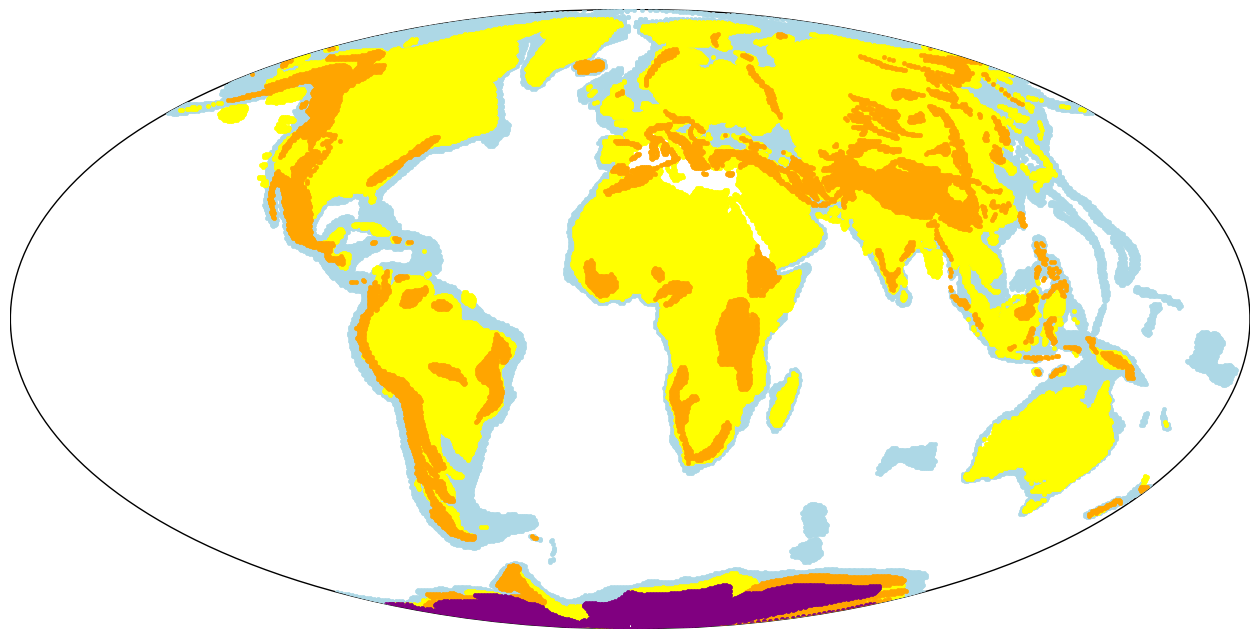

In [15]:
# Input the data for calculation
age = 6
FigNum = 64
FromAge = 11
ToAge = 2
reconstruction_time = 6

basedir = '../Data/'+str(age)+'/5_Reconstructed_Paleogeog_GolonkaIDs_'+str(age)+'Ma'
icesheet =  '%s/i_fig%d_%d_%d_reconstructed_%0.2fMa.shp' % (basedir,FigNum,FromAge,ToAge,reconstruction_time)
mountain =  '%s/m_fig%d_%d_%d_reconstructed_%0.2fMa.shp' % (basedir,FigNum,FromAge,ToAge,reconstruction_time)
landmass = '%s/lm_fig%d_%d_%d_reconstructed_%0.2fMa.shp' % (basedir,FigNum,FromAge,ToAge,reconstruction_time)
shallow_marine = '%s/sm_fig%d_%d_%d_reconstructed_%0.2fMa.shp' % (basedir,FigNum,FromAge,ToAge,reconstruction_time)

# call the functions
cookie_cut_points = PaleogeogAreas(rotation_model,reconstruction_time,icesheet,mountain,landmass,shallow_marine)
lmpc,mpc,ipc,smpc = PlotPaleogeography(cookie_cut_points,'paleogeog_equal_area_points_%0.2f.png' % reconstruction_time)

print 'Time steps = %d' % age 
print ''
print 'icesheet = %0.4f%%' % (100*ipc/num_points_on_globe)
print 'mountain = %0.4f%%' % (100*mpc/num_points_on_globe)
print 'landmass = %0.4f%%' % (100*lmpc/num_points_on_globe)
print 'shallow_marine = %0.4f%%' % (100*smpc/num_points_on_globe)
print 'deep_ocean = %0.4f%%' %(100-(100*ipc/num_points_on_globe)-(100*mpc/num_points_on_globe)-(100*lmpc/num_points_on_globe)-(100*smpc/num_points_on_globe))

print 
#print lmpc_list,mpc_list,ipc_list,smpc_list
#calculate areas
print ''
EarthArea = 4.*np.pi*pygplates.Earth.mean_radius_in_kms**2
#EarthArea = 510100000.
print EarthArea

#print 'Time step = %d Ma' % age
print 'icesheet area = %0.4f sq.km' % (EarthArea*(ipc/num_points_on_globe)/(1e7))
print 'mountain area = %0.4f sq.km' % (EarthArea*(mpc/num_points_on_globe)/(1e7))
print 'Landmass area = %0.4f sq.km' % (EarthArea*(lmpc/num_points_on_globe)/(1e7))
print 'shallow_marine area = %0.4f sq.km' % (EarthArea*(smpc/num_points_on_globe)/(1e7))
print 'deep_ocean area = %0.4f sq.km' % ((EarthArea/(1e7))-(EarthArea*(ipc/num_points_on_globe)/(1e7))-(EarthArea*(mpc/num_points_on_globe)/(1e7))-(EarthArea*(lmpc/num_points_on_globe)/(1e7))-(EarthArea*(smpc/num_points_on_globe)/(1e7)))
#print 'A_T-Land = %0.4f sq.km' % ()
#print 'Earth area= %0.2f sq.km' % (EarthArea/(1e7))